In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import socceraction

from statsbombpy import sb

In [2]:
from socceraction.data.statsbomb import StatsBombLoader

path = 'D:\Football Data Science\Data\Event\Statsbomb\data'

api = StatsBombLoader(getter="local", root=path)

df_games = {'Bundesliga': api.games(competition_id=9, season_id=27)['game_id'], # 德甲2015/2016赛季
            'LaLiga': api.games(competition_id=11, season_id=27)['game_id'], # 西甲2015/2016赛季
            'Ligue1': api.games(competition_id=7, season_id=27)['game_id'], # 法甲2015/2016赛季
            'PremierLeague': api.games(competition_id=2, season_id=27)['game_id'],  # 英超2015/2016赛季
            'SerieA': api.games(competition_id=12, season_id=27)['game_id']} # 意甲2015/2016赛季

In [3]:
X = pd.read_csv('data/X_all_old.csv', index_col=0)
Y = pd.read_csv('data/Y_all_old.csv', index_col=0)
atomic_actions = pd.read_csv('data/atomic_actions_all.csv', index_col=0)

X.shape, Y.shape, atomic_actions.shape

((5474178, 148), (5474178, 2), (5474178, 15))

In [4]:
to_delete_type = ['actiontype_keeper_pick_up_a0', 'actiontype_non_action_a0', 'actiontype_corner_a0', 'actiontype_freekick_a0',
                  'actiontype_keeper_pick_up_a1', 'actiontype_non_action_a1', 'actiontype_corner_a1', 'actiontype_freekick_a1',
                  'actiontype_keeper_pick_up_a2', 'actiontype_non_action_a2', 'actiontype_corner_a2', 'actiontype_freekick_a2']
X = X.drop(columns=to_delete_type) # 删掉这些完全没有的动作类型

X['actiontype_a0'] = X.loc[:, 'actiontype_pass_a0':'actiontype_red_card_a0'].idxmax(axis=1).str.lstrip('actiontype').str.rstrip('a0').str.strip('_')
X['actiontype_a1'] = X.loc[:, 'actiontype_pass_a1':'actiontype_red_card_a1'].idxmax(axis=1).str.lstrip('actiontype').str.rstrip('a1').str.strip('_')
X['actiontype_a2'] = X.loc[:, 'actiontype_pass_a2':'actiontype_red_card_a2'].idxmax(axis=1).str.lstrip('actiontype').str.rstrip('a2').str.strip('_')
X = X.loc[:, 'bodypart_foot_a0':] # 重新转换为分类变量

X = X.drop(columns=['bodypart_head/other_a0', 'bodypart_head/other_a1', 'bodypart_head/other_a2']) # 删除多余类别head/other

X['bodypart_a0'] = X.loc[:, 'bodypart_foot_a0':'bodypart_other_a0'].idxmax(axis=1).str.lstrip('bodypart').str.rstrip('a0').str.strip('_')
X['bodypart_a1'] = X.loc[:, 'bodypart_foot_a1':'bodypart_other_a1'].idxmax(axis=1).str.lstrip('bodypart').str.rstrip('a1').str.strip('_')
X['bodypart_a2'] = X.loc[:, 'bodypart_foot_a2':'bodypart_other_a2'].idxmax(axis=1).str.lstrip('bodypart').str.rstrip('a2').str.strip('_')
X = X.loc[:, 'period_id_a0':] # 重新转换为分类变量

X['period_id_a0'] = X['period_id_a0'].astype(int)
X['period_id_a1'] = X['period_id_a1'].astype(int)
X['period_id_a2'] = X['period_id_a2'].astype(int)

categorical_features = ['period_id_a0', 'period_id_a1', 'period_id_a2', 'actiontype_a0', 'actiontype_a1', 'actiontype_a2', 'bodypart_a0', 'bodypart_a1', 'bodypart_a2']
for col in categorical_features:
    if X[col].dtype != 'category':
        # print(col, X[col].dtype)
        X[col] = X[col].astype('category')

X

,period_id_a0,time_seconds_a0,time_seconds_overall_a0,period_id_a1,time_seconds_a1,time_seconds_overall_a1,period_id_a2,time_seconds_a2,time_seconds_overall_a2,team_1,...,dy_a2,goalscore_team,goalscore_opponent,goalscore_diff,actiontype_a0,actiontype_a1,actiontype_a2,bodypart_a0,bodypart_a1,bodypart_a2
0,1,0.4820,0.4820,1,0.4820,0.4820,1,0.4820,0.4820,True,...,0.936535,0,0,0,pass,pass,pass,foot,foot,foot
1,1,0.7085,0.7085,1,0.4820,0.4820,1,0.4820,0.4820,True,...,0.936535,0,0,0,receival,pass,pass,foot,foot,foot
2,1,0.9350,0.9350,1,0.7085,0.7085,1,0.4820,0.4820,True,...,0.936535,0,0,0,dribble,receival,pass,foot,foot,foot
3,1,1.0150,1.0150,1,0.9350,0.9350,1,0.7085,0.7085,True,...,0.000000,0,0,0,pass,dribble,receival,foot,foot,foot
4,1,1.5910,1.5910,1,1.0150,1.0150,1,0.9350,0.9350,True,...,-0.436904,0,0,0,receival,pass,dribble,foot,foot,foot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5474173,2,2930.8385,5630.8385,2,2928.5210,5628.5210,2,2927.6690,5627.6690,False,...,1.000000,1,2,-1,interception,pass,dribble,foot,foot,foot
5474174,2,2933.1560,5633.1560,2,2930.8385,5630.8385,2,2928.5210,5628.5210,True,...,-0.542151,1,2,-1,dribble,interception,pass,foot,foot,foot
5474175,2,2935.1310,5635.1310,2,2933.1560,5633.1560,2,2930.8385,5630.8385,True,...,-0.000000,1,2,-1,pass,dribble,interception,foot,foot,foot
5474176,2,2938.2210,5638.2210,2,2935.1310,5635.1310,2,2933.1560,5633.1560,False,...,0.208129,2,1,1,interception,pass,dribble,foot,foot,foot


In [5]:
result = {}
for league, series in df_games.items():
    for game_id in series:
        result[game_id] = league
folds = atomic_actions['game_id'].map(result)

leagues_info = {}
for league in df_games.keys():
    leagues_info[league] = {'games_cnt': len(df_games[league]),
                            'pass_total': len(X[(X['actiontype_a0'] == 'pass') & (folds == league)]),
                            'shot_total': len(X[(X['actiontype_a0'] == 'shot') & (folds == league)]),
                            'goal_total': len(X[(X['actiontype_a0'] == 'goal') & (folds == league)]),
                            'pass_per_game': len(X[(X['actiontype_a0'] == 'pass') & (folds == league)]) / len(df_games[league]),
                            'shot_per_game': len(X[(X['actiontype_a0'] == 'shot') & (folds == league)]) / len(df_games[league]),
                            'goal_per_game': len(X[(X['actiontype_a0'] == 'goal') & (folds == league)]) / len(df_games[league])}
leagues_info = pd.DataFrame(leagues_info).T
leagues_info['games_cnt'] = leagues_info['games_cnt'].astype(int)
leagues_info['pass_total'] = leagues_info['pass_total'].astype(int)
leagues_info['shot_total'] = leagues_info['shot_total'].astype(int)
leagues_info['goal_total'] = leagues_info['goal_total'].astype(int)

leagues_info.to_csv('leagues_info.csv')
leagues_info

,games_cnt,pass_total,shot_total,goal_total,pass_per_game,shot_per_game,goal_per_game
Bundesliga,306,255131,7370,837,833.761438,24.084967,2.735294
LaLiga,380,314978,8662,1014,828.889474,22.794737,2.668421
Ligue1,377,324497,8263,916,860.734748,21.917772,2.429708
PremierLeague,380,321046,9416,988,844.857895,24.778947,2.600000
SerieA,380,322106,9398,951,847.647368,24.731579,2.502632


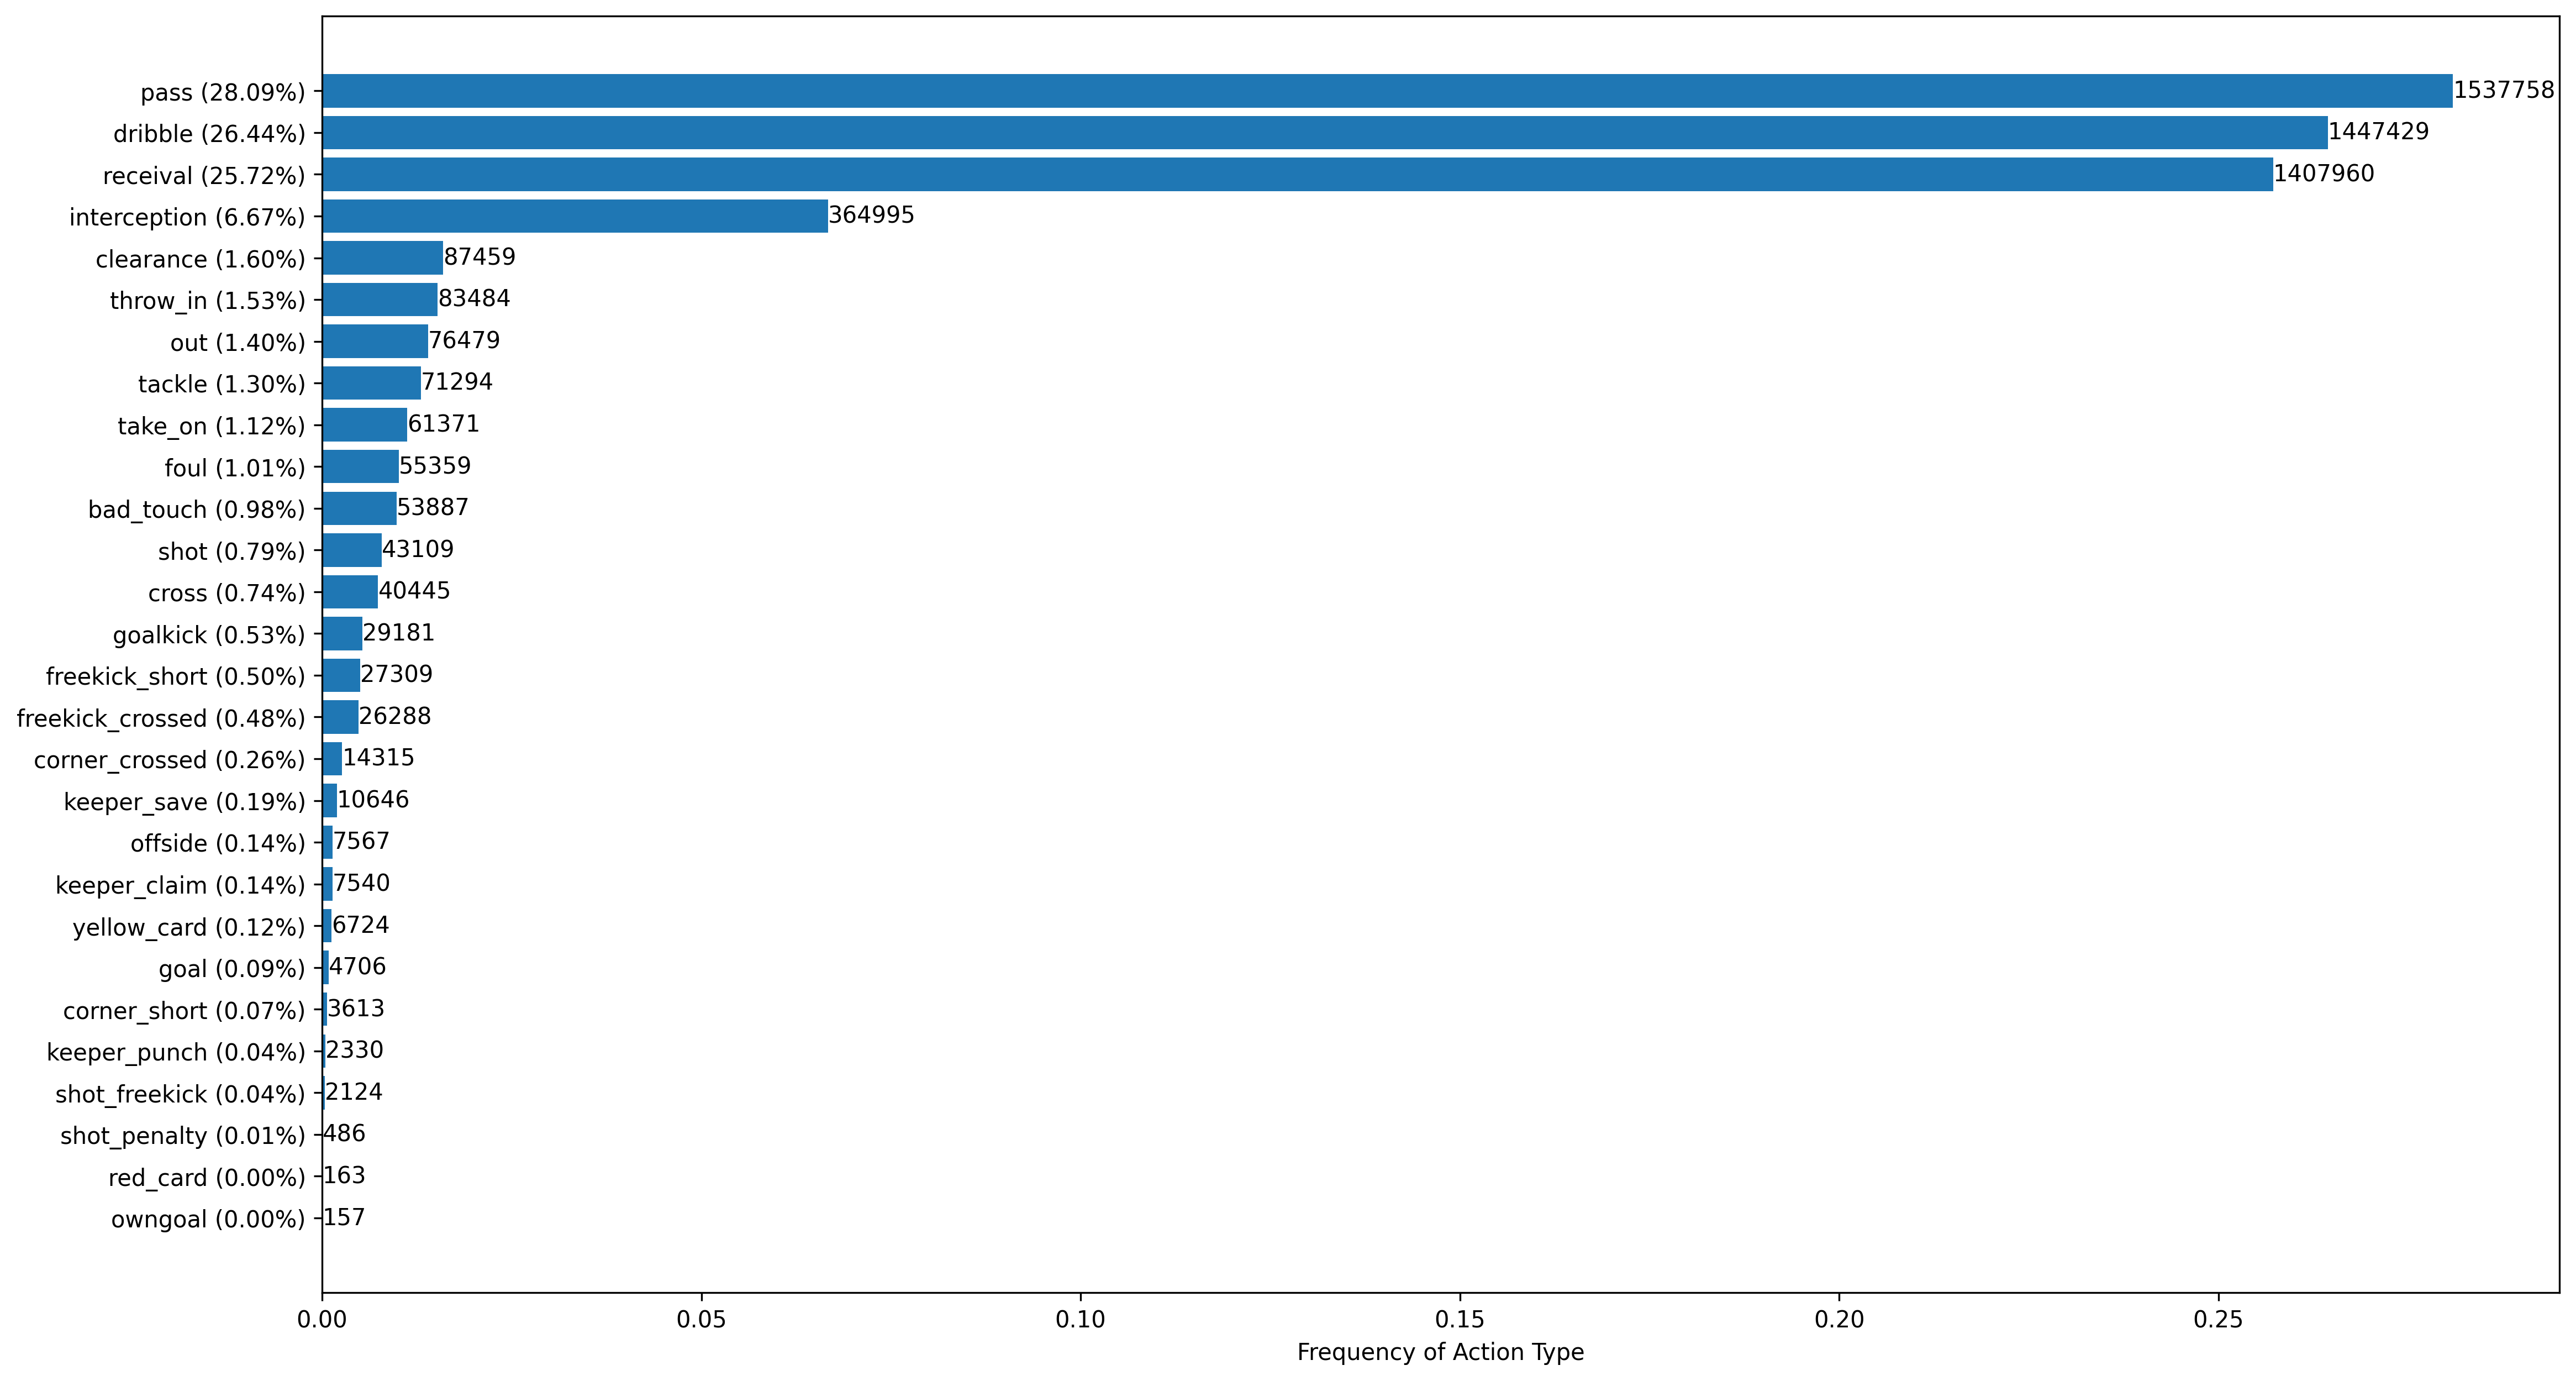

In [6]:
actiontype_cnt = X['actiontype_a0'].value_counts().sort_values()

plt.figure(dpi=300, figsize=(12,10))
bars = plt.barh(actiontype_cnt.index, actiontype_cnt / actiontype_cnt.sum())

for bar, count in zip(bars, actiontype_cnt):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, str(count), va='center', ha='left')
plt.subplots_adjust(right=1.25)

current_tick_labels = plt.yticks()[1]
new_tick_labels = []
for i, label in enumerate(current_tick_labels):
    frequency = (actiontype_cnt / actiontype_cnt.sum() * 100).iloc[i]
    new_label = f"{label.get_text()} ({frequency:.2f}%)"
    new_tick_labels.append(new_label)
plt.yticks(ticks=plt.yticks()[0], labels=new_tick_labels)

plt.xlabel('Frequency of Action Type')
plt.show()

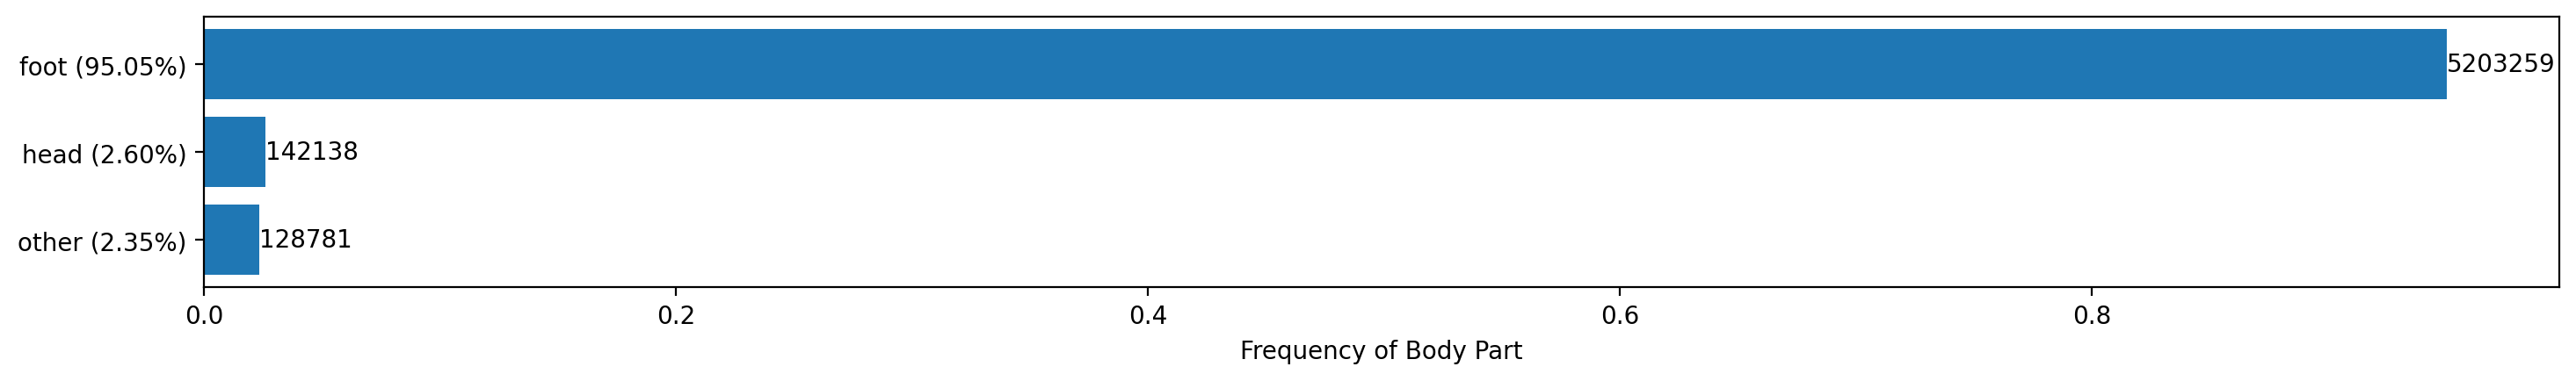

In [7]:
bodypart_cnt = X['bodypart_a0'].value_counts().sort_values()

plt.figure(dpi=200, figsize=(8,2))
bars = plt.barh(bodypart_cnt.index, bodypart_cnt / bodypart_cnt.sum())

for bar, count in zip(bars, bodypart_cnt):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, str(count), va='center', ha='left')
plt.subplots_adjust(right=1.8)

current_tick_labels = plt.yticks()[1]
new_tick_labels = []
for i, label in enumerate(current_tick_labels):
    frequency = (bodypart_cnt / bodypart_cnt.sum() * 100).iloc[i]
    new_label = f"{label.get_text()} ({frequency:.2f}%)"
    new_tick_labels.append(new_label)
plt.yticks(ticks=plt.yticks()[0], labels=new_tick_labels)

plt.xlabel('Frequency of Body Part')
plt.show()

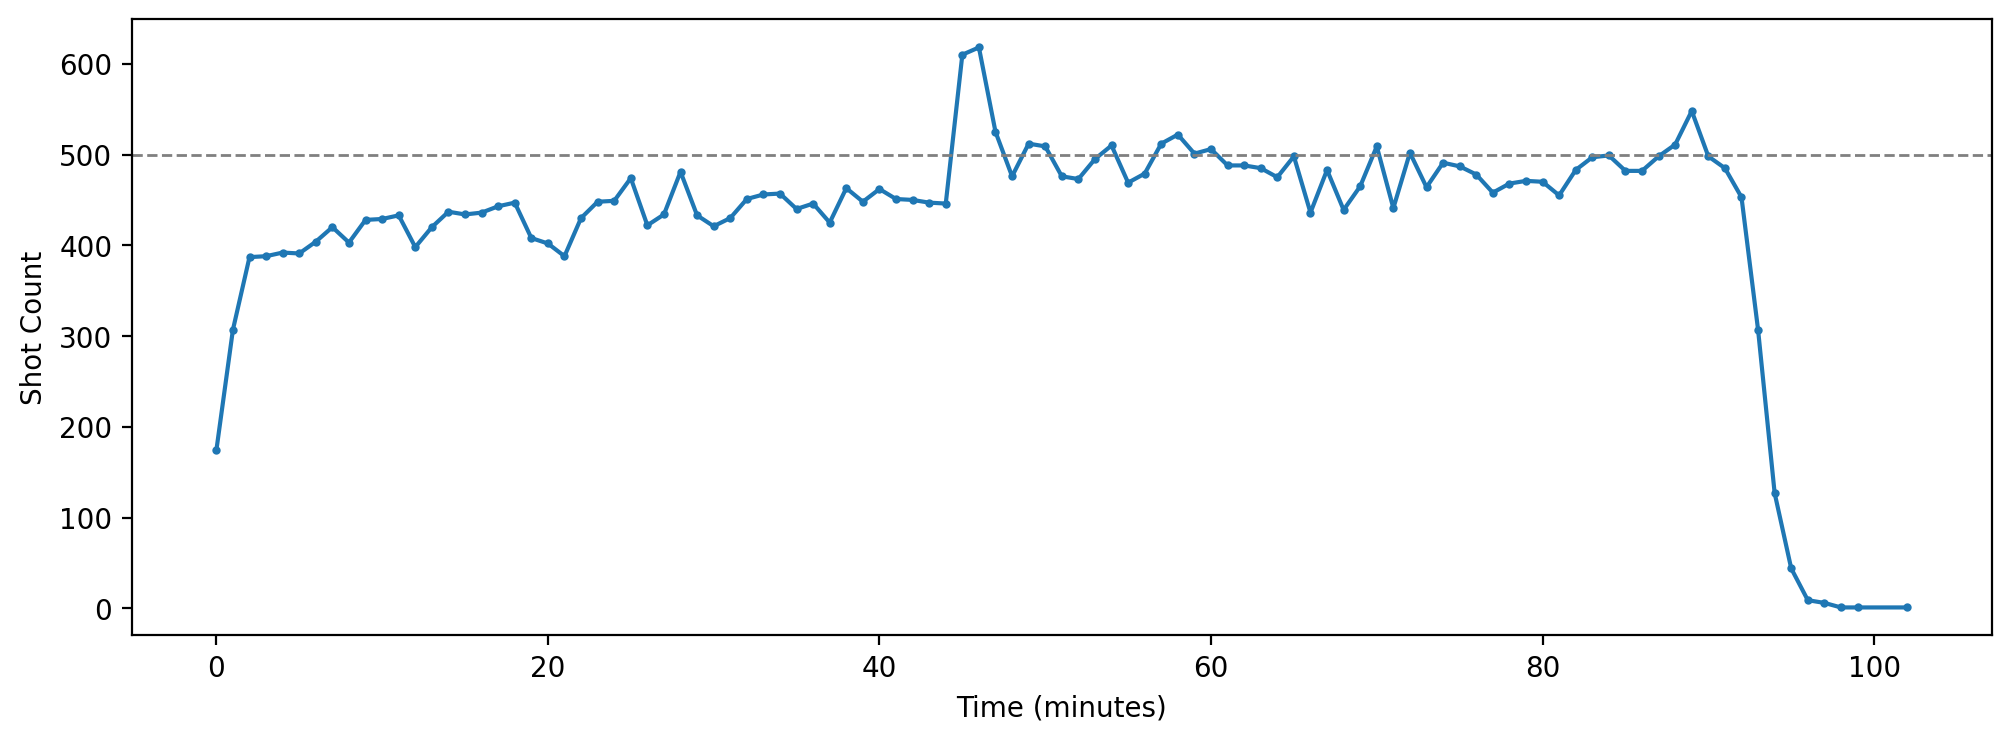

In [8]:
shot_minute_cnt = (X[X['actiontype_a0'] == 'shot']['time_seconds_overall_a0'] // 60).astype(int).value_counts().sort_index()

plt.figure(dpi=200, figsize=(12,4))
plt.plot(shot_minute_cnt.index, shot_minute_cnt, marker='o', markersize=2)
plt.axhline(y=500, color='grey', linestyle='--', linewidth=1)
plt.xlabel('Time (minutes)')
plt.ylabel('Shot Count')
plt.show()

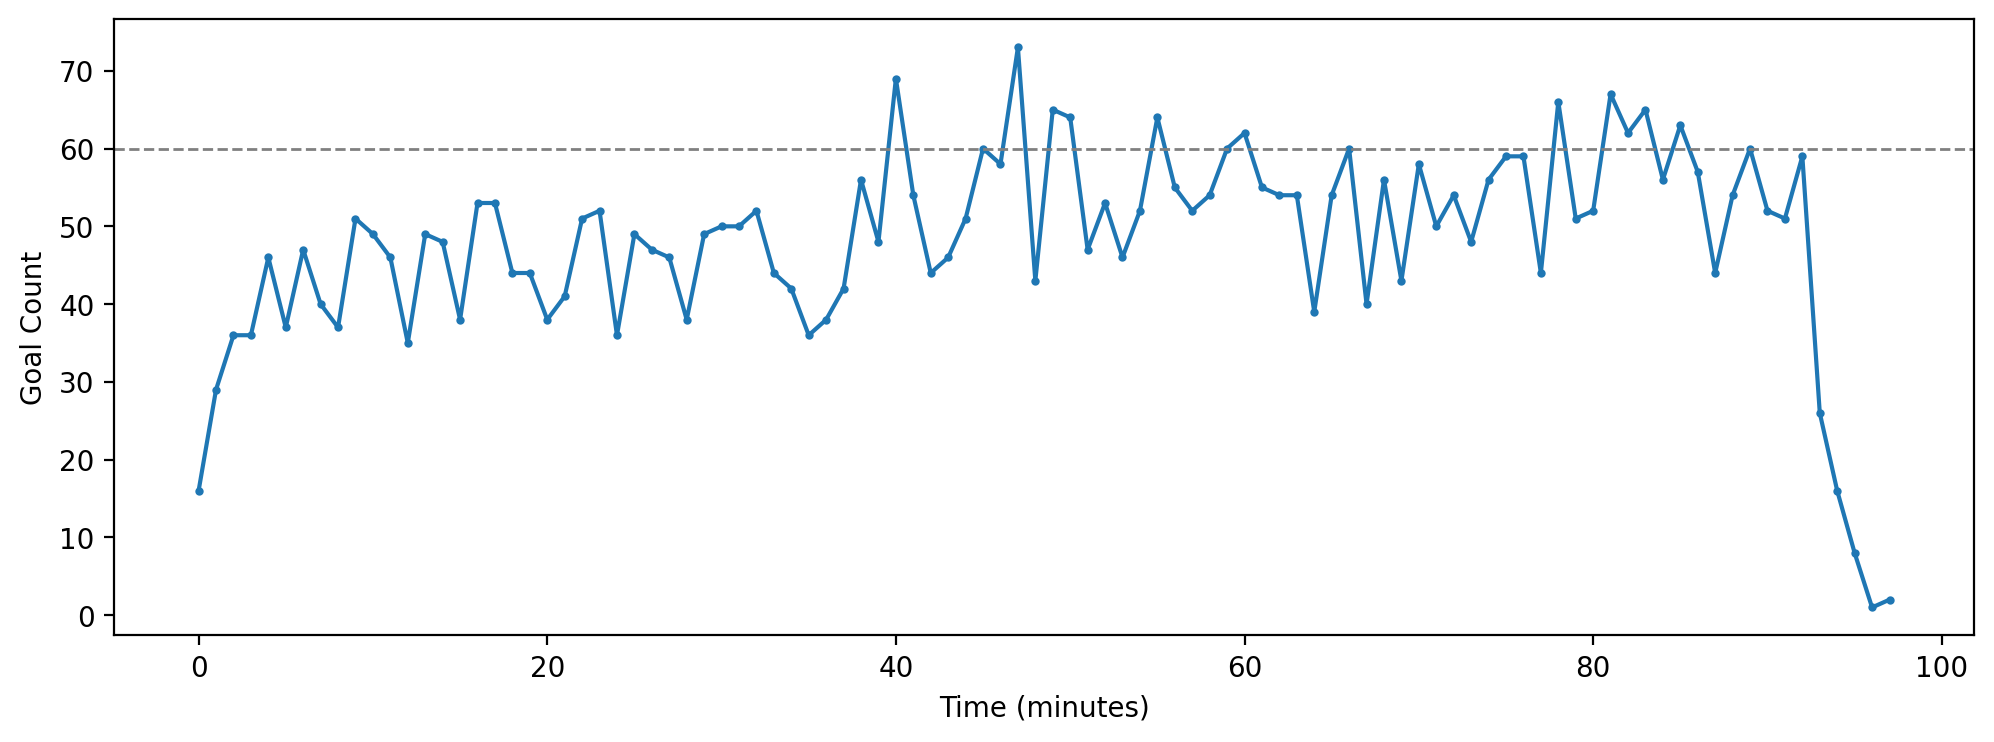

In [9]:
goal_minute_cnt = (X[X['actiontype_a0'] == 'goal']['time_seconds_overall_a0'] // 60).astype(int).value_counts().sort_index()

plt.figure(dpi=200, figsize=(12,4))
plt.plot(goal_minute_cnt.index, goal_minute_cnt, marker='o', markersize=2)
plt.axhline(y=60, color='grey', linestyle='--', linewidth=1)
plt.xlabel('Time (minutes)')
plt.ylabel('Goal Count')
plt.show()

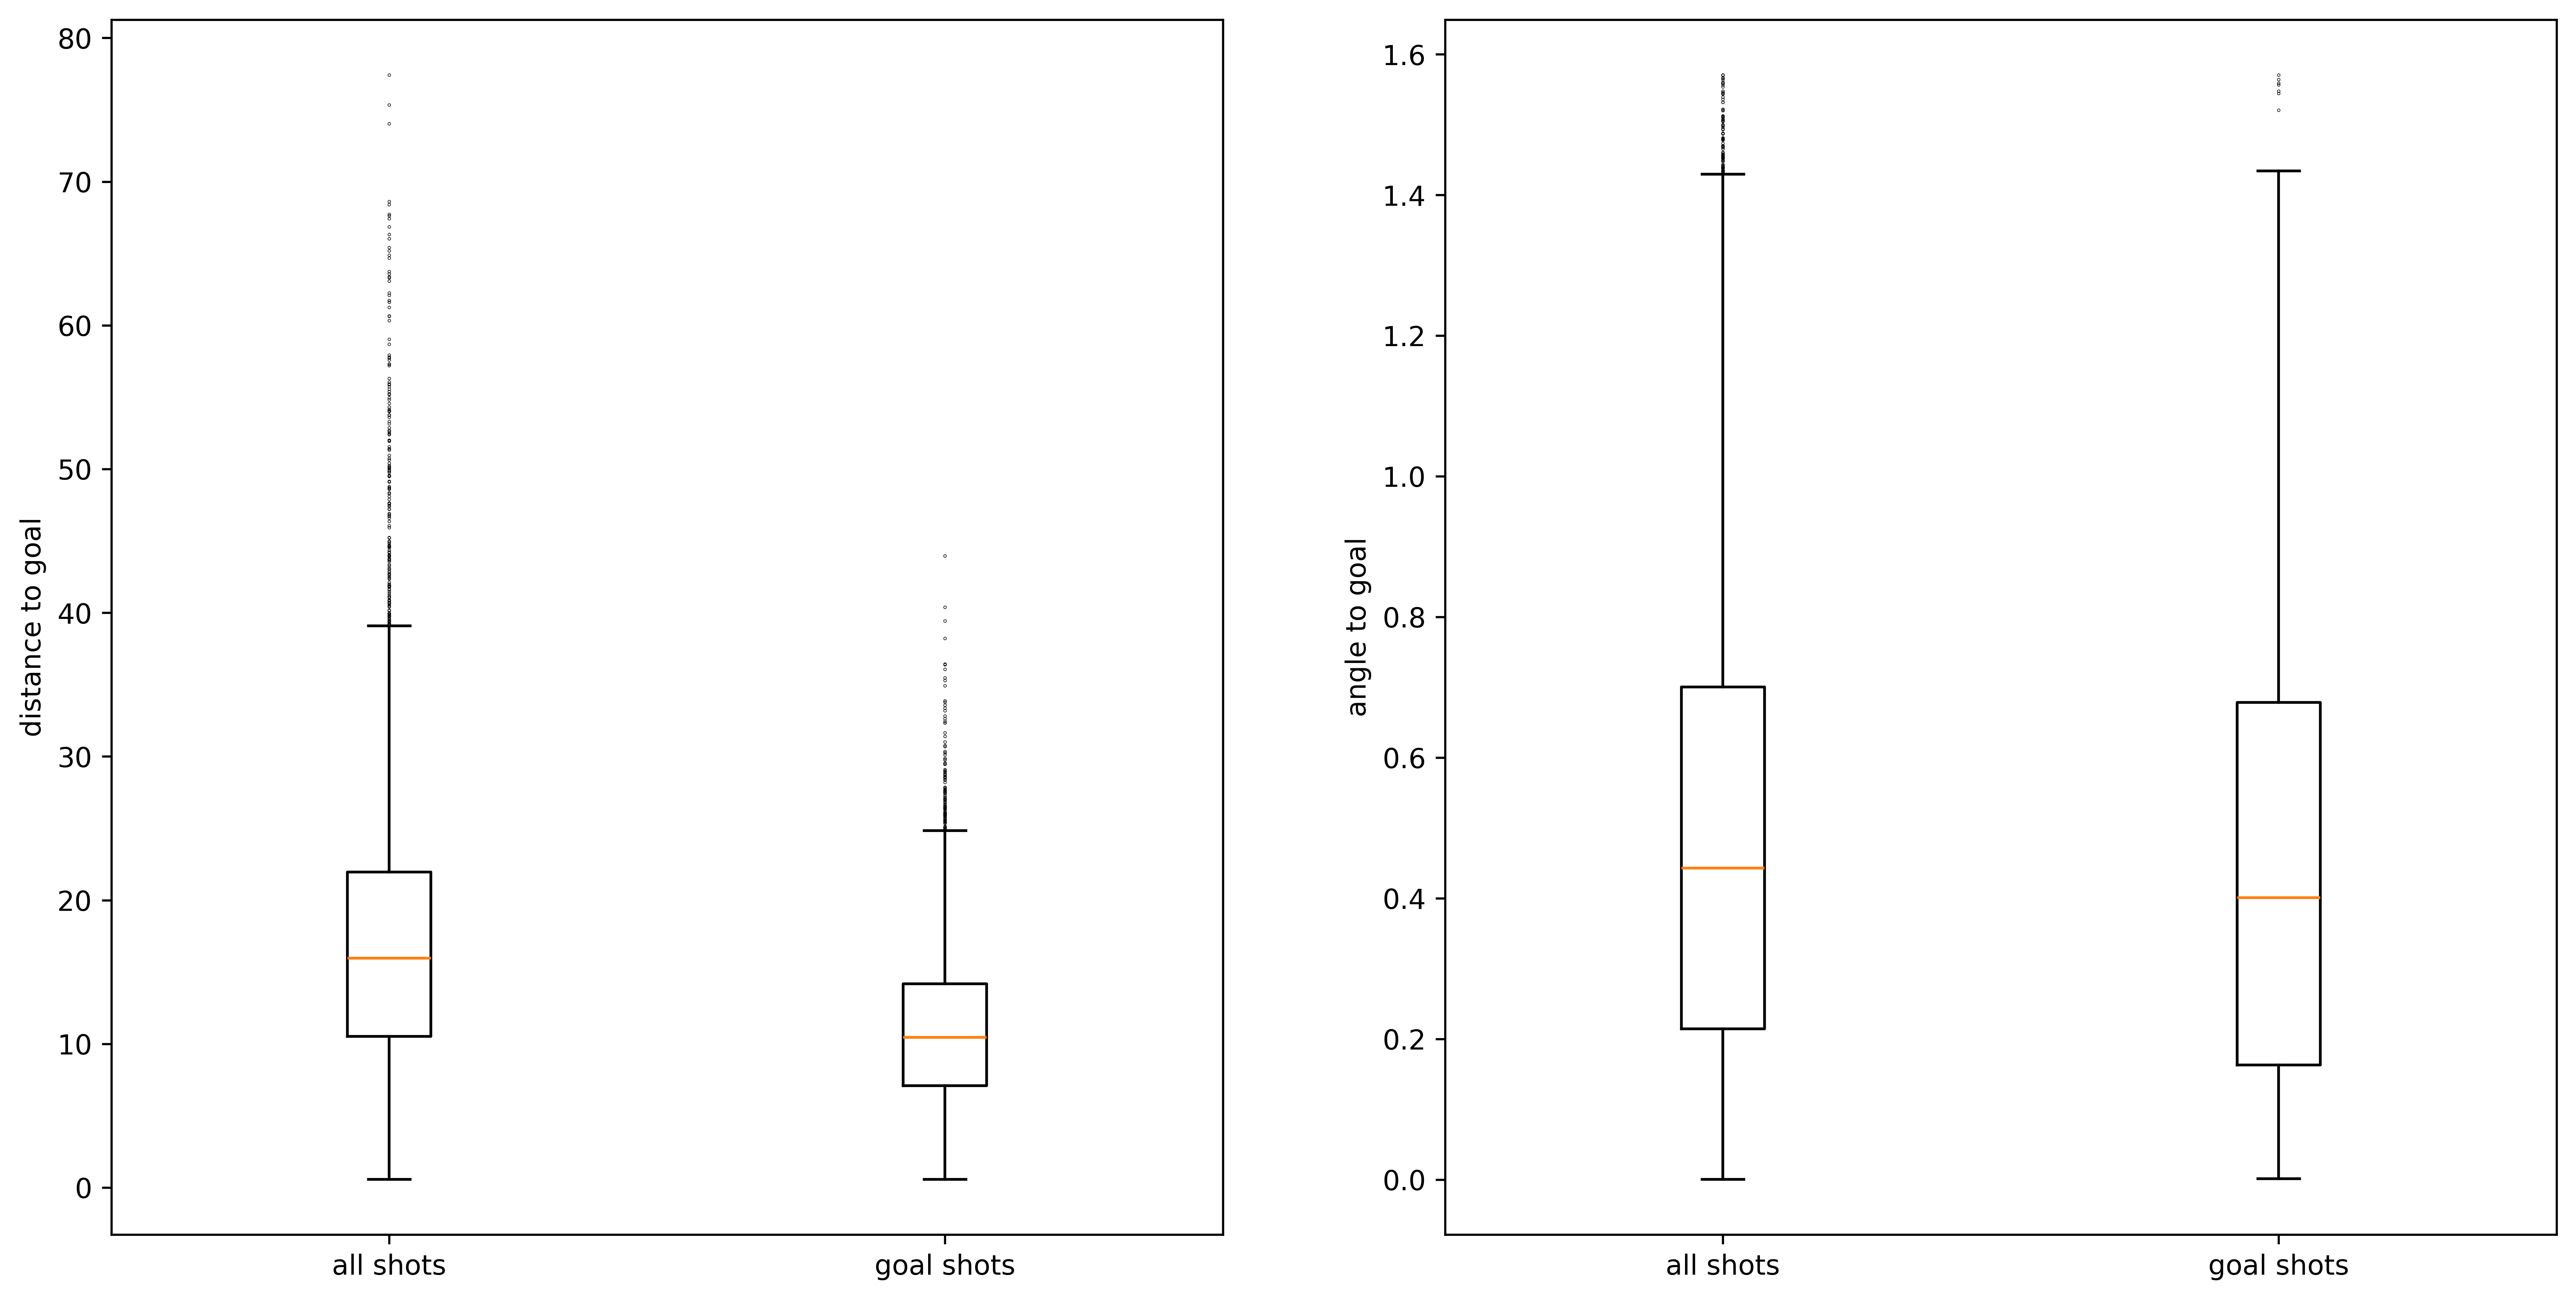

In [10]:
shot_dist = X.loc[X[X['actiontype_a0'] == 'shot'].index, 'dist_to_goal_a0']
shot_goal_dist = X.loc[X[X['actiontype_a0'] == 'goal'].index - 1, 'dist_to_goal_a0']

shot_angle = X.loc[X[X['actiontype_a0'] == 'shot'].index, 'angle_to_goal_a0']
shot_goal_angle = X.loc[X[X['actiontype_a0'] == 'goal'].index - 1, 'angle_to_goal_a0']

fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=600)

axes[0].boxplot([shot_dist, shot_goal_dist], flierprops=dict(markersize=0.2))
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(['all shots', 'goal shots'])
axes[0].set_ylabel('distance to goal')

axes[1].boxplot([shot_angle, shot_goal_angle], flierprops=dict(markersize=0.2))
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['all shots', 'goal shots'])
axes[1].set_ylabel('angle to goal')

plt.show()